#Configuracion

In [1]:
import os, re, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

RANDOM_STATE=42; TEST_SIZE=0.2
np.random.seed(RANDOM_STATE); random.seed(RANDOM_STATE)
plt.rcParams["figure.figsize"]=(10,6)
pd.set_option("display.max_colwidth", 120)
print("Listo ✅")

Listo ✅


#Carga de datos

In [2]:
from google.colab import drive
drive.mount('/content/drive')
df_raw = pd.read_csv('/content/drive/MyDrive/google_playstore_user_reviews.csv')
print("Columnas:", list(df_raw.columns)); df_raw.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Columnas: ['App', 'Translated_Review', 'Sentiment', 'Sentiment_Polarity', 'Sentiment_Subjectivity']


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,"I like eat delicious food. That's I'm cooking food myself, case ""10 Best Foods"" helps lot, also ""Best Before (Shelf ...",Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


#1. Análisis Exploratorio y Limpieza de Datos

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

# Descargar recursos de NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Cargar datos
df = df_raw

# Análisis inicial
print("=== INFORMACIÓN INICIAL DEL DATASET ===")
print(f"Dimensiones: {df.shape}")
print(f"\nColumnas: {df.columns.tolist()}")
print(f"\nTipos de datos:\n{df.dtypes}")
print(f"\nValores nulos:\n{df.isnull().sum()}")
print(f"\nDistribución de sentimientos:\n{df['Sentiment'].value_counts()}")

=== INFORMACIÓN INICIAL DEL DATASET ===
Dimensiones: (64295, 5)

Columnas: ['App', 'Translated_Review', 'Sentiment', 'Sentiment_Polarity', 'Sentiment_Subjectivity']

Tipos de datos:
App                        object
Translated_Review          object
Sentiment                  object
Sentiment_Polarity        float64
Sentiment_Subjectivity    float64
dtype: object

Valores nulos:
App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

Distribución de sentimientos:
Sentiment
Positive    23998
Negative     8271
Neutral      5163
Name: count, dtype: int64


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#2. Limpieza y Preprocesamiento

In [4]:
# Limpieza de datos
def clean_data(df):
    # Eliminar filas con valores nulos en columnas críticas
    df_clean = df.dropna(subset=['Translated_Review', 'Sentiment'])

    # Filtrar solo los sentimientos principales
    valid_sentiments = ['Positive', 'Negative', 'Neutral']
    df_clean = df_clean[df_clean['Sentiment'].isin(valid_sentiments)]

    # Limpiar texto
    df_clean = df_clean[df_clean['Translated_Review'].str.len() > 2]

    return df_clean

df_clean = clean_data(df)

print(f"Dataset después de limpieza: {df_clean.shape}")
print(f"Distribución final de sentimientos:\n{df_clean['Sentiment'].value_counts()}")

# Preprocesamiento de texto
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if isinstance(text, str):
        # Convertir a minúsculas
        text = text.lower()
        # Eliminar caracteres especiales y números
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Tokenizar y lematizar
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        return ' '.join(tokens)
    return ''

df_clean['Cleaned_Review'] = df_clean['Translated_Review'].apply(preprocess_text)
df_clean.head()

Dataset después de limpieza: (37343, 5)
Distribución final de sentimientos:
Sentiment
Positive    23948
Negative     8271
Neutral      5124
Name: count, dtype: int64


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Cleaned_Review
0,10 Best Foods for You,"I like eat delicious food. That's I'm cooking food myself, case ""10 Best Foods"" helps lot, also ""Best Before (Shelf ...",Positive,1.00,0.533333,like eat delicious food thats im cooking food case best food help lot also best shelf life
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462,help eating healthy exercise regular basis
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000,work great especially going grocery store
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000,best idea u
5,10 Best Foods for You,Best way,Positive,1.00,0.300000,best way


In [5]:
#Completitud
completitud = pd.DataFrame(df_clean.isnull().sum())
completitud.reset_index(inplace = True)
completitud = completitud.rename(columns = {"index":"columna",0:"total"})
completitud["completitud"] = (1 - completitud["total"] / df.shape[0]) * 100
completitud = completitud.sort_values(by = "completitud", ascending = True)
completitud.reset_index(drop = True, inplace = True)
completitud

,columna,total,completitud
0,App,0,100.0
1,Translated_Review,0,100.0
2,Sentiment,0,100.0
3,Sentiment_Polarity,0,100.0
4,Sentiment_Subjectivity,0,100.0
5,Cleaned_Review,0,100.0


#3. Visualizacion de datos

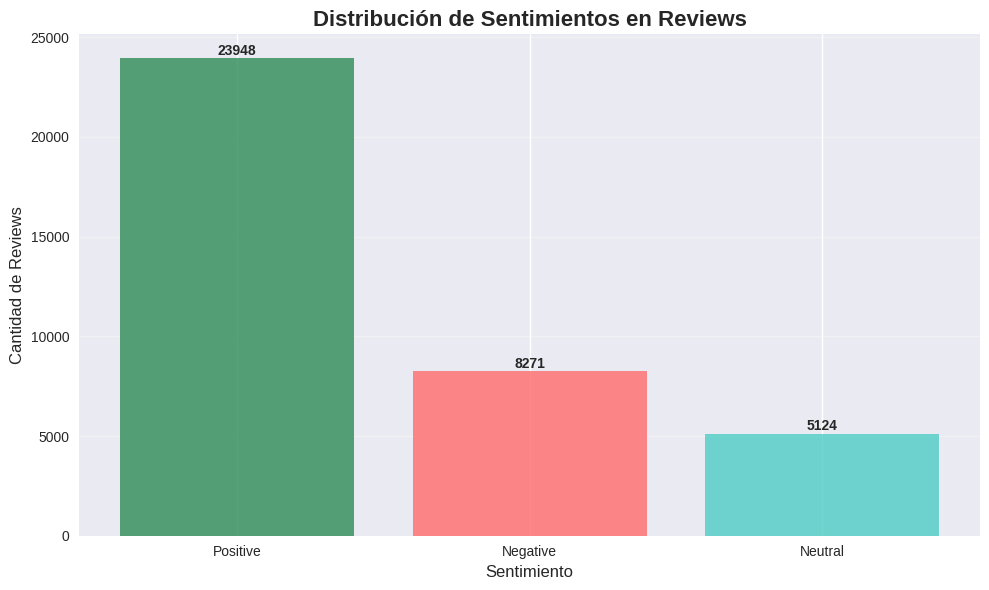

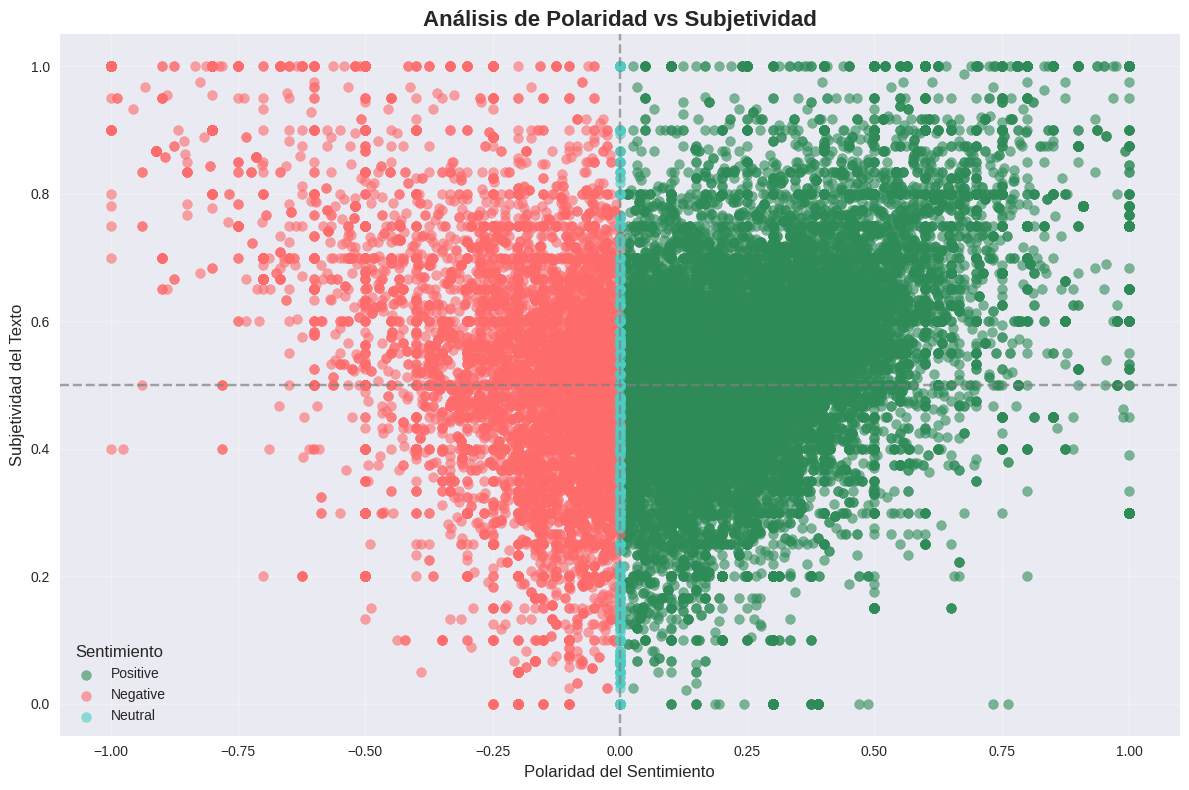

In [6]:
# Configuración de estilo para gráficas
plt.style.use('seaborn-v0_8')
colors = ['#2E8B57', '#FF6B6B', '#4ECDC4']

# Gráfica 1: Distribución de sentimientos
plt.figure(figsize=(10, 6))
sentiment_counts = df_clean['Sentiment'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors, alpha=0.8)
plt.title('Distribución de Sentimientos en Reviews', fontsize=16, fontweight='bold')
plt.xlabel('Sentimiento', fontsize=12)
plt.ylabel('Cantidad de Reviews', fontsize=12)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# Gráfica 2: Polaridad vs Subjetividad por sentimiento
plt.figure(figsize=(12, 8))
for i, sentiment in enumerate(['Positive', 'Negative', 'Neutral']):
    subset = df_clean[df_clean['Sentiment'] == sentiment]
    plt.scatter(subset['Sentiment_Polarity'], subset['Sentiment_Subjectivity'],
               alpha=0.6, color=colors[i], label=sentiment, s=50)

plt.title('Análisis de Polaridad vs Subjetividad', fontsize=16, fontweight='bold')
plt.xlabel('Polaridad del Sentimiento', fontsize=12)
plt.ylabel('Subjetividad del Texto', fontsize=12)
plt.legend(title='Sentimiento', title_fontsize=12, fontsize=10)
plt.grid(alpha=0.3)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#4. Preparación de Datos para Modelado

In [7]:
df_clean.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Cleaned_Review
0,10 Best Foods for You,"I like eat delicious food. That's I'm cooking food myself, case ""10 Best Foods"" helps lot, also ""Best Before (Shelf ...",Positive,1.00,0.533333,like eat delicious food thats im cooking food case best food help lot also best shelf life
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462,help eating healthy exercise regular basis
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000,work great especially going grocery store
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000,best idea u
5,10 Best Foods for You,Best way,Positive,1.00,0.300000,best way


In [8]:
# Preparar características y variable objetivo
X = df_clean['Cleaned_Review']
y = df_clean['Sentiment']

# Vectorización TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_vectorized = vectorizer.fit_transform(X)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X_vectorized, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")

Tamaño del conjunto de entrenamiento: 29874
Tamaño del conjunto de prueba: 7469


#5. Modelado Base

In [9]:
# Modelo base - Random Forest
base_model = RandomForestClassifier(n_estimators=100, random_state=42)
base_model.fit(X_train, y_train)
y_pred_base = base_model.predict(X_test)

# Métricas del modelo base
base_accuracy = accuracy_score(y_test, y_pred_base)
print(f"Precisión del modelo base: {base_accuracy:.4f}")
print("\nReporte de clasificación - Modelo Base:")
print(classification_report(y_test, y_pred_base))

Precisión del modelo base: 0.9059

Reporte de clasificación - Modelo Base:
              precision    recall  f1-score   support

    Negative       0.93      0.75      0.83      1654
     Neutral       0.84      0.89      0.86      1025
    Positive       0.91      0.96      0.94      4790

    accuracy                           0.91      7469
   macro avg       0.90      0.87      0.88      7469
weighted avg       0.91      0.91      0.90      7469



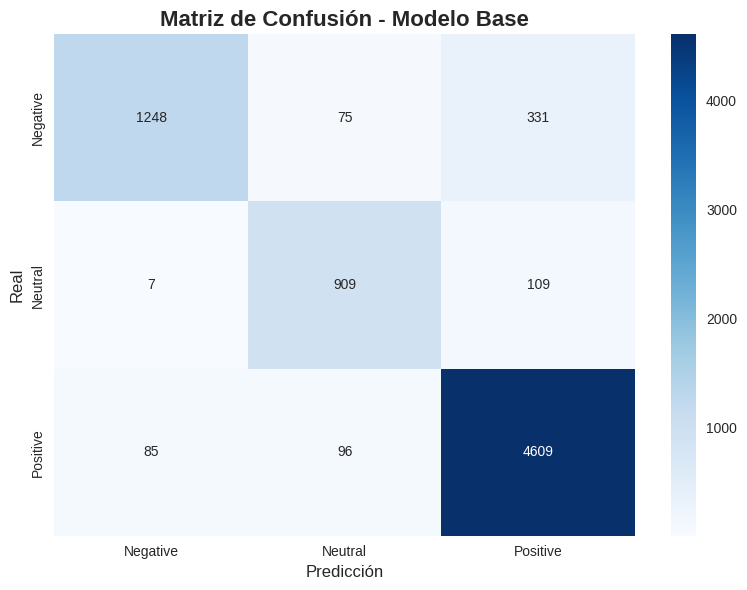

In [10]:
# Matriz de confusión del modelo base
plt.figure(figsize=(8, 6))
cm_base = confusion_matrix(y_test, y_pred_base)
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Matriz de Confusión - Modelo Base', fontsize=16, fontweight='bold')
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.tight_layout()
plt.show()

#6. Ensemble y Optimización

In [ ]:
# Crear ensemble de modelos
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42)
}

# Ensemble por votación
ensemble_model = VotingClassifier(
    estimators=[('rf', models['Random Forest']),
                ('svm', models['SVM']),
                ('lr', models['Logistic Regression'])],
    voting='soft'
)

ensemble_model.fit(X_train, y_train)
y_pred_ensemble = ensemble_model.predict(X_test)

# Métricas del ensemble
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Precisión del ensemble: {ensemble_accuracy:.4f}")
print("\nReporte de clasificación - Ensemble:")
print(classification_report(y_test, y_pred_ensemble))

In [ ]:
# Matriz de confusión del modelo ensemble
plt.figure(figsize=(8, 6))
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Matriz de Confusión - Modelo Ensemble', fontsize=16, fontweight='bold')
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.tight_layout()
plt.show()

#7. Optimización de Hiperparámetros

In [ ]:
# Optimización para Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Mejor modelo optimizado
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)

print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Precisión del modelo optimizado: {best_accuracy:.4f}")

#8. Métricas de Rendimiento y Gráficas

In [ ]:
# Gráfica 3: Comparación de precisiones
models_comparison = ['Base', 'Ensemble', 'Optimizado']
accuracies = [base_accuracy, ensemble_accuracy, best_accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(models_comparison, accuracies, color=['#FF9999', '#66B2FF', '#99FF99'], alpha=0.8)
plt.title('Comparación de Precisión entre Modelos', fontsize=16, fontweight='bold')
plt.xlabel('Modelos', fontsize=12)
plt.ylabel('Precisión', fontsize=12)
plt.ylim(0, 1)

# Añadir valores en las barras
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{accuracy:.4f}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Métricas detalladas
print("=== MÉTRICAS DETALLADAS ===")
print(f"Precisión Base: {base_accuracy:.4f}")
print(f"Precisión Ensemble: {ensemble_accuracy:.4f}")
print(f"Precisión Optimizado: {best_accuracy:.4f}")
print(f"Mejora respecto al base: {((best_accuracy - base_accuracy) / base_accuracy * 100):.2f}%")

In [ ]:
# Determine the best model based on accuracy
models_accuracy = {
    'Base Model': base_accuracy,
    'Ensemble Model': ensemble_accuracy,
    'Optimized Model': best_accuracy
}

best_model_name = max(models_accuracy, key=models_accuracy.get)
best_accuracy_score = models_accuracy[best_model_name]

print(f"The best performing model is: {best_model_name} with an accuracy of {best_accuracy_score:.4f}")

# Get the predictions of the best model
if best_model_name == 'Base Model':
    y_pred_best_model = y_pred_base
elif best_model_name == 'Ensemble Model':
    y_pred_best_model = y_pred_ensemble
else: # Optimized Model
    y_pred_best_model = y_pred_best

# Matriz de confusión del mejor modelo
plt.figure(figsize=(8, 6))
cm_best_model = confusion_matrix(y_test, y_pred_best_model)
sns.heatmap(cm_best_model, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title(f'Matriz de Confusión - {best_model_name}', fontsize=16, fontweight='bold')
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_ensemble, average="macro", zero_division=0)
print(f"Ensemble | Acc: {ensemble_accuracy:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f} | F1: {f1:.3f}")

#Guardado

In [ ]:
import pickle
import joblib

# Guardar el modelo optimizado
with open('sentiment_model.pkl', 'wb') as f:
    #pickle.dump(best_model, f)
    pickle.dump(ensemble_model, f) #fue el que tuvo mejor puntuacion

# Guardar el vectorizer (ESTO ES LO QUE FALTABA)
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# También puedes usar joblib para objetos grandes
#joblib.dump(best_model, 'sentiment_model.joblib')
joblib.dump(ensemble_model, 'sentiment_model.joblib') #mejor puntuacion
joblib.dump(vectorizer, 'vectorizer.joblib')

print("✅ Modelo y vectorizer guardados exitosamente")
print("📁 Archivos creados:")
print("   - sentiment_model.pkl")
print("   - vectorizer.pkl")
print("   - sentiment_model.joblib")
print("   - vectorizer.joblib")


In [ ]:
import joblib

try:
    # Load the best model (based on previous output, ensemble had the best score)
    loaded_model = joblib.load('sentiment_model.joblib')
    print("✅ Successfully loaded sentiment_model.joblib")

    # Load the vectorizer
    loaded_vectorizer = joblib.load('vectorizer.joblib')
    print("✅ Successfully loaded vectorizer.joblib")

    # Sample text for prediction
    sample_review = "This app is amazing! I love it."

    # Preprocess the sample text (using a simplified approach for demonstration)
    # In a real application, you would use the same preprocessing steps as during training.
    # For now, we'll just ensure it's a string.
    preprocessed_review = [sample_review] # Vectorizer expects an iterable

    # Vectorize the sample text
    vectorized_review = loaded_vectorizer.transform(preprocessed_review)
    print("✅ Successfully vectorized sample review")

    # Predict the sentiment
    prediction = loaded_model.predict(vectorized_review)
    print(f"\nSample Review: '{sample_review}'")
    print(f"Predicted Sentiment: {prediction[0]}")

except FileNotFoundError as e:
    print(f"❌ Error loading file: {e}. Please ensure the saving cell was run.")
except Exception as e:
    print(f"❌ An error occurred: {e}")

In [ ]:
import joblib

try:
    # Load the best model (based on previous output, ensemble had the best score)
    loaded_model = joblib.load('/content/drive/MyDrive/ULTIMO/sentiment_model.joblib')
    print("✅ Successfully loaded sentiment_model.joblib")

    # Load the vectorizer
    loaded_vectorizer = joblib.load('/content/drive/MyDrive/ULTIMO/vectorizer.joblib')
    print("✅ Successfully loaded vectorizer.joblib")

    # Sample text for prediction
    sample_review = "This app is hate!t."

    # Preprocess the sample text (using a simplified approach for demonstration)
    # In a real application, you would use the same preprocessing steps as during training.
    # For now, we'll just ensure it's a string.
    preprocessed_review = [sample_review] # Vectorizer expects an iterable

    # Vectorize the sample text
    vectorized_review = loaded_vectorizer.transform(preprocessed_review)
    print("✅ Successfully vectorized sample review")

    # Predict the sentiment
    prediction = loaded_model.predict(vectorized_review)
    print(f"\nSample Review: '{sample_review}'")
    print(f"Predicted Sentiment: {prediction[0]}")

except FileNotFoundError as e:
    print(f"❌ Error loading file: {e}. Please ensure the saving cell was run.")
except Exception as e:
    print(f"❌ An error occurred: {e}")

In [ ]:
#Para ver las versiones a configurar
import sklearn, joblib
print("scikit-learn:", sklearn.__version__)
print("joblib:", joblib.__version__)

# 9. API REST con Flask

In [ ]:
!pip install flask --quiet
!pip install flask-ngrok --quiet
print("Completed!")

In [ ]:
#Respaldo del que funciona
from flask import Flask, request, jsonify
import joblib, os
import numpy as np

app = Flask(__name__)

MODEL_PATH = "sentiment_model.joblib"
VECT_PATH  = "vectorizer.joblib"

modelo = joblib.load(MODEL_PATH)
vectorizer = joblib.load(VECT_PATH)

if not hasattr(vectorizer, "idf_"):
    raise RuntimeError("El vectorizer.joblib no está ajustado (falta idf_). Vuelve a guardarlo tras fit.")

@app.route("/")
def home():
    return jsonify({
        "mensaje": "✅ API de Análisis de Sentimientos (:) 3 clases) funcionando correctamente",
        "uso": "Envía un POST a /predict con un JSON {'texto': 'tu frase aquí'}"
    })

@app.route("/predict", methods=["POST"])
def predict():
    try:
        data = request.get_json(silent=True) or {}
        if "texto" not in data:
            return jsonify({"error": "Falta el campo 'texto'"}), 400

        texto = data["texto"]
        if not isinstance(texto, str) or not texto.strip():
            return jsonify({"error": "El campo 'texto' debe ser un string no vacío"}), 400

        X = vectorizer.transform([texto])

        # Predicción (etiqueta 'positivo'/'neutral'/'negativo')
        pred = modelo.predict(X)[0]

        confianza_pct = None
        probs_pct = None

        if hasattr(modelo, "predict_proba"):
            proba = modelo.predict_proba(X)[0]           # array de probs por clase
            cls = modelo.classes_                         # orden de clases
            # prob. de la clase predicha:
            conf = proba[np.argmax(proba)]
            confianza_pct = round(float(conf) * 100, 2)   # porcentaje
            # (opcional) todas las clases en porcentaje
            probs_pct = {str(c): round(float(p)*100, 2) for c, p in zip(cls, proba)}

        elif hasattr(modelo, "decision_function"):
            # Nota: no son probabilidades calibradas. Para porcentajes reales usa CalibratedClassifierCV
            score = modelo.decision_function(X)
            # manejo binario vs multiclase
            if np.ndim(score) == 1:
                # escala min-max para que al menos sea interpretable (no probabilístico)
                s = float(score[0])
                confianza_pct = "No disponible (usar predict_proba/calibración)"
            else:
                confianza_pct = "No disponible (usar predict_proba/calibración)"
        else:
            confianza_pct = "No disponible (modelo no soporta probabilidades)"

        return jsonify({
            "texto": texto,
            "sentimiento": pred,
            "confianza_pct": confianza_pct,
        })
    except Exception as e:
        return jsonify({"error": str(e)}), 500

if __name__ == "__main__":
    app.run(debug=True, port=5000)
